In [637]:
import datetime
import pandas as pd
from xgboost import XGBClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
import random

## Data Preprocessing

In [638]:
def preprocessing(file):
    #* 讀取資料
    stock_data = pd.read_excel(file)
    stock_data = stock_data.drop(columns=['證券代碼'])
    #? print(stock_data)

    #* 擷取股票年月與簡稱
    stock_year = stock_data['年月'].unique()
    stock_name = stock_data['簡稱'].unique()
    #? print(stock_year)
    #? print(stock_name)

    #* 移除第2009年
    stock = stock_data[stock_data['年月'].isin(stock_year[:-1])]
    #? print(stock)
    
    return stock_data

## Normalization

In [639]:
def normalization(data):
    for col in data.columns[2:-2]:
        data[col] = (data[col] - data[col].min()) / (data[col].max() - data[col].min())
        
    return data

## Split train and test by TV(1997~2008)

In [640]:
def split_train_test(stock, TV):
    #* 擷取股票年月與
    stock_year = stock['年月'].unique()
    
    basic_train_data = stock[stock['年月'].isin(stock_year[:TV])]
    train_label = basic_train_data['ReturnMean_year_Label']
    train_data = basic_train_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])

    basic_test_data = stock[stock['年月'].isin(stock_year[TV:])]
    test_label = basic_test_data['ReturnMean_year_Label']
    test_data = basic_test_data.drop(columns=['簡稱', '年月', 'Return', 'ReturnMean_year_Label'])
    
    return train_data, train_label, test_data, test_label

## Genetic Algorithm

### 染色體解碼

In [641]:
def decode(chromosome):
    dna_len = len(chromosome)
    code = 0
    for i in range(dna_len):
        gene = dna_len - i - 1
        code += chromosome[gene] * (2**i)
    
    return code

### 初始種群

In [642]:
def initial_population(pop_num, dna_length):
    population = []
    for i in range(pop_num):
        chromosome = np.ones(dna_length, np.bool8)     
        chromosome[:int(0.3 * dna_length)] = False             
        np.random.shuffle(chromosome)
        population.append(chromosome)
    # print(population)
    return population

### 適應度

In [643]:
def fitness(data, pop):
    train_data, train_label, test_data, test_label = data
    
    scores = []
    model = XGBClassifier()
    for chromosome in pop:
        model.fit(train_data.values[:, chromosome], train_label) 
        predictions = model.predict(test_data.values[:, chromosome])
        test_score = metrics.accuracy_score(test_label, predictions)
        scores.append(test_score) # 準確率
        
    scores, pop = np.array(scores), np.array(pop) 
    inds = np.argsort(scores)
    return list(pop[inds, :][::-1]), list(scores[inds][::-1])  # my_list[start(開始的index):end(結束的index):sep(間隔)]

### 選擇

In [644]:
def selection(data, pop):
    ran_F = random.choices(pop, k=2)
    ran_M = random.choices(pop, k=2)
    
    ran_F, sort_F = fitness(data, ran_F)
    ran_M, sort_M = fitness(data, ran_M)

    father = ran_F[0]
    mother = ran_M[0]

    return father, mother

### 交配

In [645]:
def cross(data, pop, cross_rate=0.7):
    pop_size, dna_len = np.array(pop).shape
    new_pop = []
    while len(new_pop) != pop_size:
        father, mother = selection(data, pop)

        if np.random.rand() < cross_rate:
            cross_point = np.random.randint(low=0, high=dna_len)
            cut_F = father[cross_point:].copy()
            cut_M = mother[cross_point:].copy()
            father[cross_point:] = cut_M
            mother[cross_point:] = cut_F
            
        new_pop.extend([father, mother])
        
    return new_pop

### 變異

In [646]:
def mutation(cross_pop, mutation_rate=0.005):
    pop_size, dna_len = np.array(cross_pop).shape
    new_pop = []
    for i in range(pop_size):
        if np.random.rand() < mutation_rate:
            mutation_point = np.random.randint(low=0, high=dna_len)
            if cross_pop[i][mutation_point] == 0:
                cross_pop[i][mutation_point] = 1
            else:
                cross_pop[i][mutation_point] = 0
                
        new_pop.append(cross_pop[i])

    return new_pop

### 分析

#### 計算種群適應度最佳值及平均值

In [647]:
def best_avg_fitness(score):
    return np.max(score), np.mean(score)

#### 繪製種群狀態

In [648]:
def draw_fitness(run, best_pop, avg_pop):
    plt.title("Best & Avg fitness") # 圖表標題
    plt.xlabel("Generation") # 圖表x軸標題
    plt.ylabel("fitness") # 圖表y軸標題
    plt.plot(run, best_pop, color='r', label='Best fitness', linestyle='-', marker='*') # 定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.plot(run, avg_pop, color='b', label='Avg fitness', linestyle='--', marker='o') # 定義畫圖的顏色、圖例、線條、形狀、寬度
    plt.grid(axis='y') # 定義網格
    plt.legend(loc='lower right') # 當有兩種以上資料，可以使用.legend()來顯示資料的圖例
    plt.savefig('GA_XGBoost.png')

## Main Function

[Generation 1]
Best chromosome: [False  True  True  True  True  True  True False  True False  True  True
  True False  True  True]
Best fitness: 0.6583333333333333
Avg fitness: 0.6250416666666667

[Generation 2]
Best chromosome: [ True  True  True  True  True  True False  True  True  True False False
  True  True  True  True]
Best fitness: 0.65
Avg fitness: 0.6273333333333334

[Generation 3]
Best chromosome: [ True  True  True  True  True  True False  True  True  True False False
  True  True  True  True]
Best fitness: 0.65
Avg fitness: 0.6295833333333334

[Generation 4]
Best chromosome: [ True False  True  True  True  True False  True  True  True False False
  True False  True  True]
Best fitness: 0.655
Avg fitness: 0.63225

[Generation 5]
Best chromosome: [ True False  True  True  True  True False  True  True  True False False
  True False  True  True]
Best fitness: 0.655
Avg fitness: 0.6373333333333333

[Generation 6]
Best chromosome: [ True False  True  True  True  True False  True

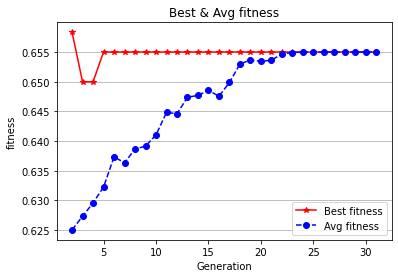

In [649]:
if __name__=="__main__":
    TV = 10
    
    file_path = './top200_training.xls'
    stock = preprocessing(file_path)
    normalized_stock = normalization(stock)
    train_data, train_label, test_data, test_label = split_train_test(normalized_stock, TV)
    #* Remap the labels
    train_label = train_label.map({-1:0, 1:1})
    test_label = test_label.map({-1:0, 1:1})
    
    data = [train_data, train_label, test_data, test_label]
    
    #* 設定GA參數    
    POP_SIZE = 80 # 種群大小
    DNA_LEN = 16 # 染色體長度: 16個特徵
    
    cross_rate = 0.7 # 交配機率
    mutation_rate = 0.001 # 變異機率
    
    #* 初始種群
    pop = initial_population(POP_SIZE, DNA_LEN)

    #* 迭代次數
    generation_num = 30
    
    #* early stopping
    overfit_num = 0
    
    i = 0
    best_fitness_list = []
    avg_fitness_list = []
    run = []
    while overfit_num < 3 and i < generation_num: # best fitness & average fitness 連續相等3次則中斷
        print(f"[Generation {i + 1}]")
        cross_pop = cross(data, pop, cross_rate) # 選擇 -> 交配
        mutation_pop = mutation(cross_pop, mutation_rate) # 變異
        pop = mutation_pop
        i += 1
        
        pop, score = fitness(data, pop)
        print(f"Best chromosome: {pop[0]}")
        best_fitness, average_fitness = best_avg_fitness(score)
        print(f"Best fitness: {best_fitness}")
        print(f"Avg fitness: {average_fitness}\n")
        best_fitness_list.append(best_fitness)
        avg_fitness_list.append(average_fitness)
        run.append(i + 1)
        
        #* early stopping
        if best_fitness == average_fitness:
            overfit_num += 1
        else:
            overfit_num = 0
        
    print(f"[TV{TV}]")
    best_chromosome = pop[0]
    print(f"Best_Chromosome: {best_chromosome}")
    
    #! test result
    print(f"測試結果:")
    test_model = XGBClassifier()
    test_model.fit(train_data.values[:, best_chromosome], train_label)
    
    #* predict label
    predictions = test_model.predict(test_data.values[:, best_chromosome])
    print(predictions)
    
    #* test accuracy
    test_score = metrics.accuracy_score(test_label, predictions)
    print(f"score: {test_score}")
    
    #! fitness picture
    draw_fitness(run, best_fitness_list, avg_fitness_list)